In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import Normalize 
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interpn
from scipy.stats import spearmanr
from sklearn.metrics.cluster import normalized_mutual_info_score
import os

In [2]:
flat_dir = '/home/m/monroy/rubin-user/spec_flats/wl_dependence/outputs/'

In [3]:
#flat_label = 'normalised_flat_{0}_{1}-{2}.fits'
flat_label = 'regular_flat_{0}_{1}-{2}.fits'

In [4]:
disperser = 'empty'

In [5]:
filter_blue = 'SDSSg_65mm'
filter_red = 'SDSSz_65mm'
filter_0 = 'empty'
filter_blue_short = 'SDSSg'
filter_red_short = 'SDSSz'
filter_0_short = 'empty'

In [6]:
id_blue = 2024041700090 #SDSSg
id_red = 2024041700119 #SDSSz
#id_red = 2024041700217 #SDSSr
id_0 = 2024041700177 #empty

In [7]:
outdir = flat_dir

In [8]:
flat_blue = fits.open(os.path.join(flat_dir,flat_label.format(id_blue,filter_blue,disperser)))
flat_red = fits.open(os.path.join(flat_dir,flat_label.format(id_red,filter_red,disperser)))
flat_0 = fits.open(os.path.join(flat_dir,flat_label.format(id_0,filter_0,disperser)))

In [9]:
flat_shape = flat_red[1].data.shape
flat_shape

(4000, 4072)

In [10]:
ampli_coords = np.load(os.path.join(flat_dir,'LATISS_amplifier_coordinates.npy'),allow_pickle=True).ravel()[0]

In [11]:
ampli_coords

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [12]:
ampli_seq = ['C10','C11','C12','C13','C14','C15','C16','C17','C00','C01','C02','C03','C04','C05','C06','C07']

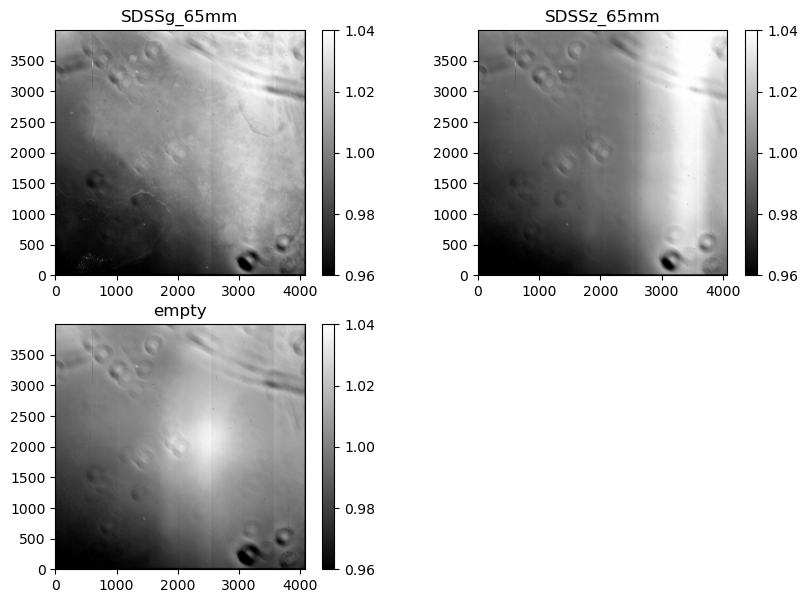

In [13]:
#%matplotlib widget
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
im = ax1.imshow(flat_blue[1].data,cmap="gray",origin='lower',vmin=0.96,vmax=1.04)
ax1.set_title(filter_blue)
fig.colorbar(im,ax=ax1)

ax2 = fig.add_subplot(222)
im = ax2.imshow(flat_red[1].data,cmap="gray",origin='lower',vmin=0.96,vmax=1.04)
ax2.set_title(filter_red)
fig.colorbar(im,ax=ax2)

ax3 = fig.add_subplot(223)
im = ax3.imshow(flat_0[1].data,cmap="gray",origin='lower',vmin=0.96,vmax=1.04)
ax3.set_title(filter_0)
fig.colorbar(im,ax=ax3)

### Define functions 

In [14]:
def pearson_coeff(x,y):
    std_x = np.std(x)
    std_y = np.std(y)
    cov_xy = np.cov(x,y)[0,1]
    coeff = cov_xy/(std_x*std_y)
    return coeff

In [15]:
corr_dict = {}
for i,ampli_ in enumerate(ampli_seq):
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue = flat_blue[1].data[y0_:y1_,x0_:x1_].flatten()
    dred = flat_red[1].data[y0_:y1_,x0_:x1_].flatten()

    rp_ = pearson_coeff(dblue,dred)
    rs_ = spearmanr(dblue,dred,axis=0)[0]
    #nmi_ = normalized_mutual_info_score(dblue,dred)
    
    corr_dict[ampli_] = (rp_,rs_)#,nmi_)

rp_all = pearson_coeff(flat_blue[1].data.flatten(),flat_red[1].data.flatten())
rs_all = spearmanr(flat_blue[1].data.flatten(),flat_red[1].data.flatten(),axis=0)[0]
#nmi_all = normalized_mutual_info_score(flat_blue[1].data.flatten(),flat_red[1].data.flatten())
corr_dict['all'] = (rp_all,rs_all)#,nmi_all)


### Correlation coefficients / scores 

/tmp/ipykernel_2930/887235305.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)


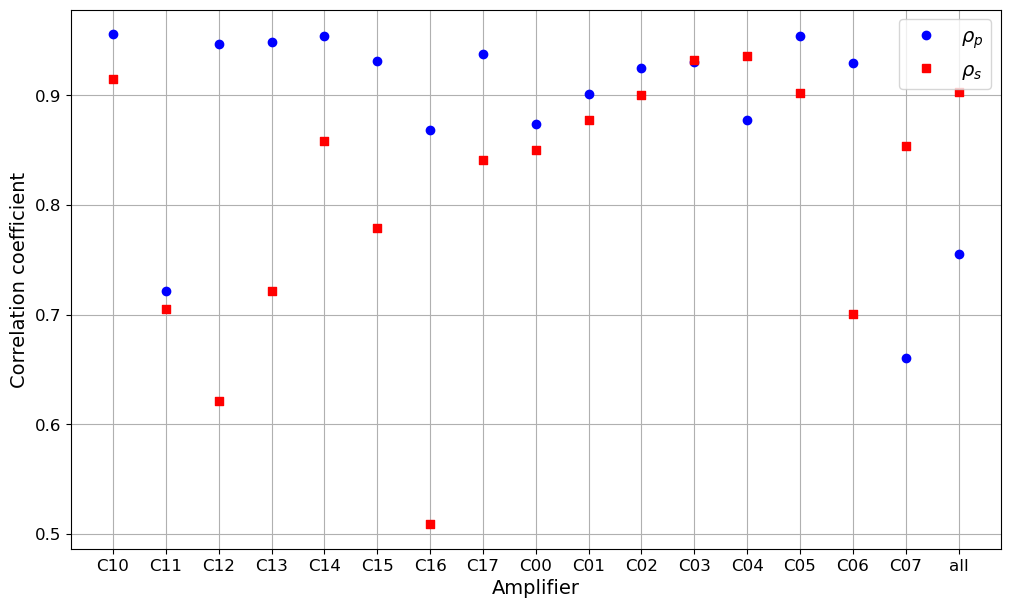

In [16]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)

for i,ampli_ in enumerate(corr_dict.keys()):
    ax.scatter(i,corr_dict[ampli_][0],marker='o',color='b',zorder=2)
    ax.scatter(i,corr_dict[ampli_][1],marker='s',color='r',zorder=2)
    #ax.scatter(i,corr_dict[ampli_][2],marker='^',color='orange',zorder=2)
ax.plot([],[],ls='',marker='o',color='b',label=r'$\rho_p$')
ax.plot([],[],ls='',marker='s',color='r',label=r'$\rho_s$')
#ax.plot([],[],ls='',marker='^',color='orange',label=r'$NMI$')
ax.grid()
ax.set_xlabel('Amplifier',fontsize=14)
ax.set_ylabel('Correlation coefficient',fontsize=14)
ax.set_xticks(np.arange(len(corr_dict.keys())))
ax.set_xticklabels(corr_dict.keys(),fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
ax.legend(loc="best",fontsize=14)
#plt.tight_layout()
plt.savefig(os.path.join(outdir,'correlation_coeffs_{0}_{1}_{2}.png'.format(filter_blue,filter_red,disperser)))

## For the paper 

### Dispersion plots 

In [17]:
def make_2d_histogram(dred,dblue,percent,val_min,val_max,fig,ax,title,do_cax=False):
    
    std_red = np.std(dred)
    std_blue = np.std(dblue)
    
    ddiff = dblue-dred
    mean_diff = np.average(ddiff)
    
    # Create the 2D histogram
    nbins = 200
    #hist, x_edges, y_edges, im = ax_main.hist2d(dred, dblue, bins=nbins, range=[(fval_min,fval_max),(fval_min,fval_max)], cmap='jet')
    H, xedges, yedges = np.histogram2d(dred,dblue,bins=500,range=[(val_min,val_max),(val_min,val_max)])
     
    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)
     
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    
    im = ax.pcolormesh(xedges,yedges,Hmasked,cmap='jet')
    x_ = np.linspace(val_min,val_max,100)
    ax.plot(x_,x_,color='r') 
    ax.set_xlim(val_min,val_max)
    ax.set_ylim(val_min,val_max)
    ax.grid()
    
    coeff_rb_p = pearson_coeff(dred,dblue)
    coeff_rb_s = spearmanr(dred,dblue)[0]
    #nmi_score = normalized_mutual_info_score(dred,dblue)
    ax.plot([],[],ls='',label=r'$\rho_{p} = $'+'{0}'.format(coeff_rb_p.round(3)))
    ax.plot([],[],ls='',label=r'$\rho_{s} = $'+'{0}'.format(coeff_rb_s.round(3)))
    #ax.plot([],[],ls='',label=r'$NMI = $'+'{0}'.format(nmi_score.round(3)))
    
    ax.plot(x_,x_+mean_diff,ls='--',color='k')
    ax.plot(x_,x_+mean_diff*(1.+percent/100.),ls=':',color='k')
    ax.plot(x_,x_+mean_diff*(1.-percent/100.),ls=':',color='k')
    
    ax.set_xlabel(filter_red_short)
    ax.set_ylabel(filter_blue_short)

    ax.set_xticks(ax.get_xticks(),ax.get_xticklabels())
    ax.set_yticks(ax.get_yticks(),ax.get_yticklabels())
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=45.,ha='right')
    #ax.set_yticklabels(ax.get_yticklabels(),rotation=45.,ha='right')
    
    axins1 = inset_axes(
        ax,
        width="50%",  # width: 50% of parent_bbox width
        height="5%",  # height: 5%
        loc="upper left",
    )
    axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(im, cax=axins1, orientation="horizontal")
    
    ax.legend(loc="lower right",handlelength=0, handletextpad=0)
    
    if do_cax:
        cax_red = fig.add_axes([ax.get_position().x0,ax.get_position().y1+0.02,ax.get_position().x1-ax.get_position().x0,0.15])
        _ = cax_red.hist(dred,bins=500, range=(fval_min,fval_max), color='r')
        cax_red.set_xlim(fval_min,fval_max)
        cax_red.grid()
        
        cax_blue = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.15,ax.get_position().y1-ax.get_position().y0])
        _ = cax_blue.hist(dblue,bins=500, range=(fval_min,fval_max), orientation='horizontal', color='b')
        cax_blue.set_ylim(fval_min,fval_max)
        cax_blue.grid()
        
        cax_red.plot([],[],ls='',label=r'$\sigma_{red} = $'+'{0:.2f}'.format(std_red))
        cax_blue.plot([],[],ls='',label=r'$\sigma_{blue} = $'+'{0:.2f}'.format(std_blue))
        
        # Remove ticks from marginal histograms
        cax_red.tick_params(axis="x", labelbottom=False)
        cax_blue.tick_params(axis="y", labelleft=False)
        
        cax_red.legend(loc="best",handlelength=0, handletextpad=0)
        cax_blue.legend(loc="best",handlelength=0, handletextpad=0)
        cax_red.set_title(title)
    else:
        ax.set_title(title)

    return ax
    

In [18]:
#Limits for plotting histograms 
fval_min = 0.90
fval_max = 1.10

/tmp/ipykernel_2930/3265723040.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/3265723040.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/3265723040.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/3265723040.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)


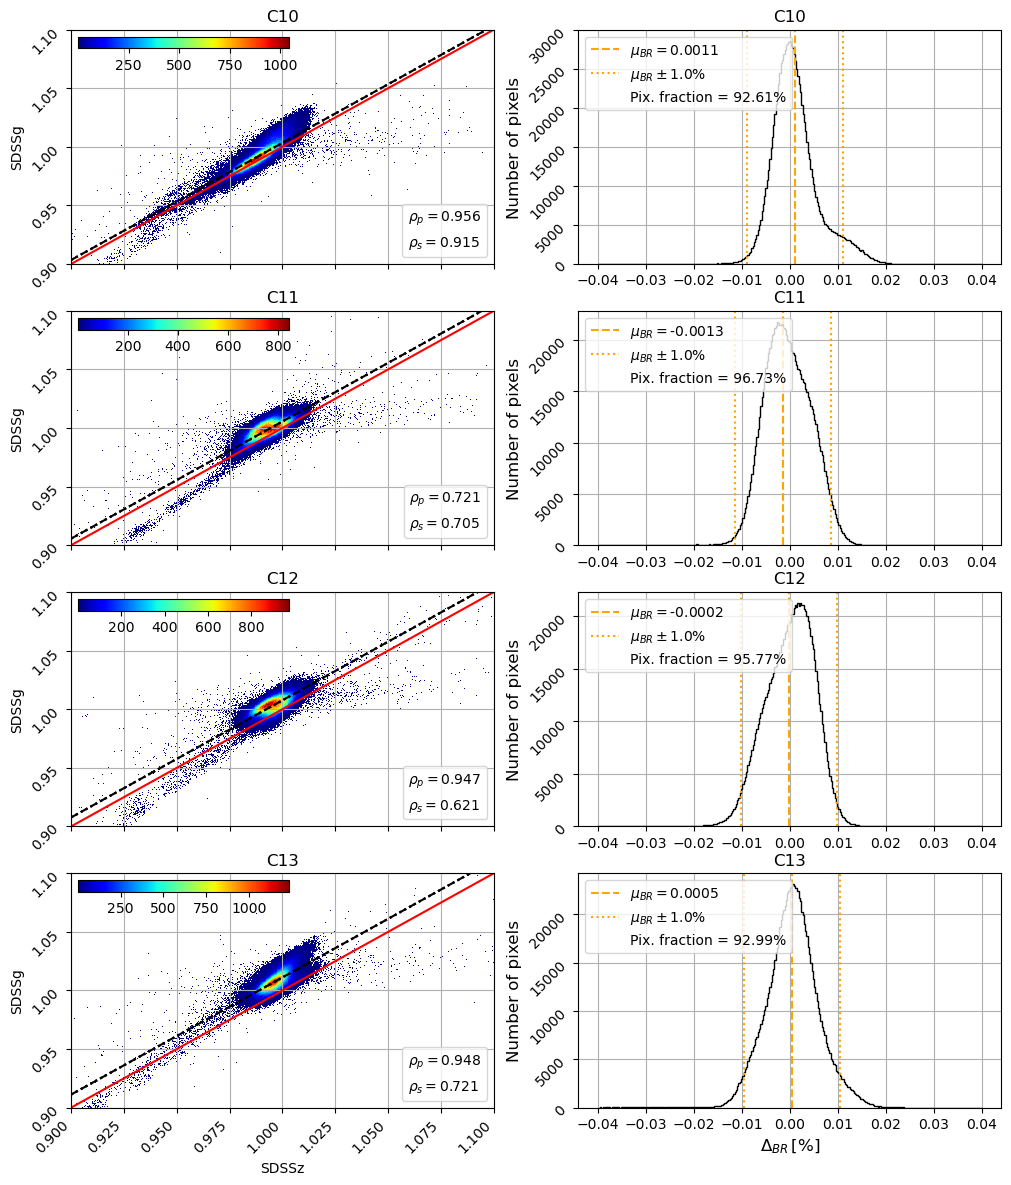

In [19]:
%matplotlib inline
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12,14))

percent = 1.0

for i,ampli_ in enumerate(ampli_seq[:4]):
    #print(ampli_)
    
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue_ = flat_blue[1].data[y0_:y1_,x0_:x1_].flatten()
    dred_ = flat_red[1].data[y0_:y1_,x0_:x1_].flatten()
    
    make_2d_histogram(dred_,dblue_,percent,fval_min,fval_max,fig,axs[i,0],ampli_)

    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(),rotation=45.,ha='right')
    axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(),rotation=45.,ha='right')
    if i!=nrows-1:
        axs[i,0].set_xlabel('')
        axs[i,0].set_xticklabels([])

    
    dblue_ = dblue_/np.median(dblue_)
    dred_ = dred_/np.median(dred_)
    dper_filters_ = (dblue_-dred_)/dred_
    mean_per_filters_ = np.mean(dper_filters_)

    per_mask_ = (dper_filters_>=-percent/100.)*(dper_filters_<=percent/100.)
    pixels_in_ = len(dper_filters_[per_mask_])*100./len(dper_filters_)
    
    axs[i,1].hist(dper_filters_,bins=300,range=(-0.04,0.04),histtype='step',color='k')
    axs[i,1].axvline(x=mean_per_filters_,ls='--',color='orange',label=r'$\mu_{BR} = $'+'{0:.4f}'.format(mean_per_filters_))
    axs[i,1].axvline(x=mean_per_filters_+percent/100.,ls=':',color='orange',label=r'$\mu_{BR} \pm $'+'{0}%'.format(percent))
    axs[i,1].axvline(x=mean_per_filters_-percent/100.,ls=':',color='orange')
    axs[i,1].plot([],[],ls='',label='Pix. fraction = {0:.2f}%'.format(pixels_in_))
    axs[i,1].grid()
    axs[i,1].set_xlabel(r'$\Delta_{BR} \, [\%]$',fontsize=12)
    axs[i,1].set_ylabel('Number of pixels',fontsize=12)
    axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
    axs[i,1].set_title(ampli_)
    axs[i,1].legend(loc="upper left")
    
    if i!=nrows-1:
        axs[i,1].set_xlabel('')
    
plt.savefig(os.path.join(outdir,'dispersion_plots_up_paper_1.png'))


/tmp/ipykernel_2930/142941178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/142941178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/142941178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/142941178.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)


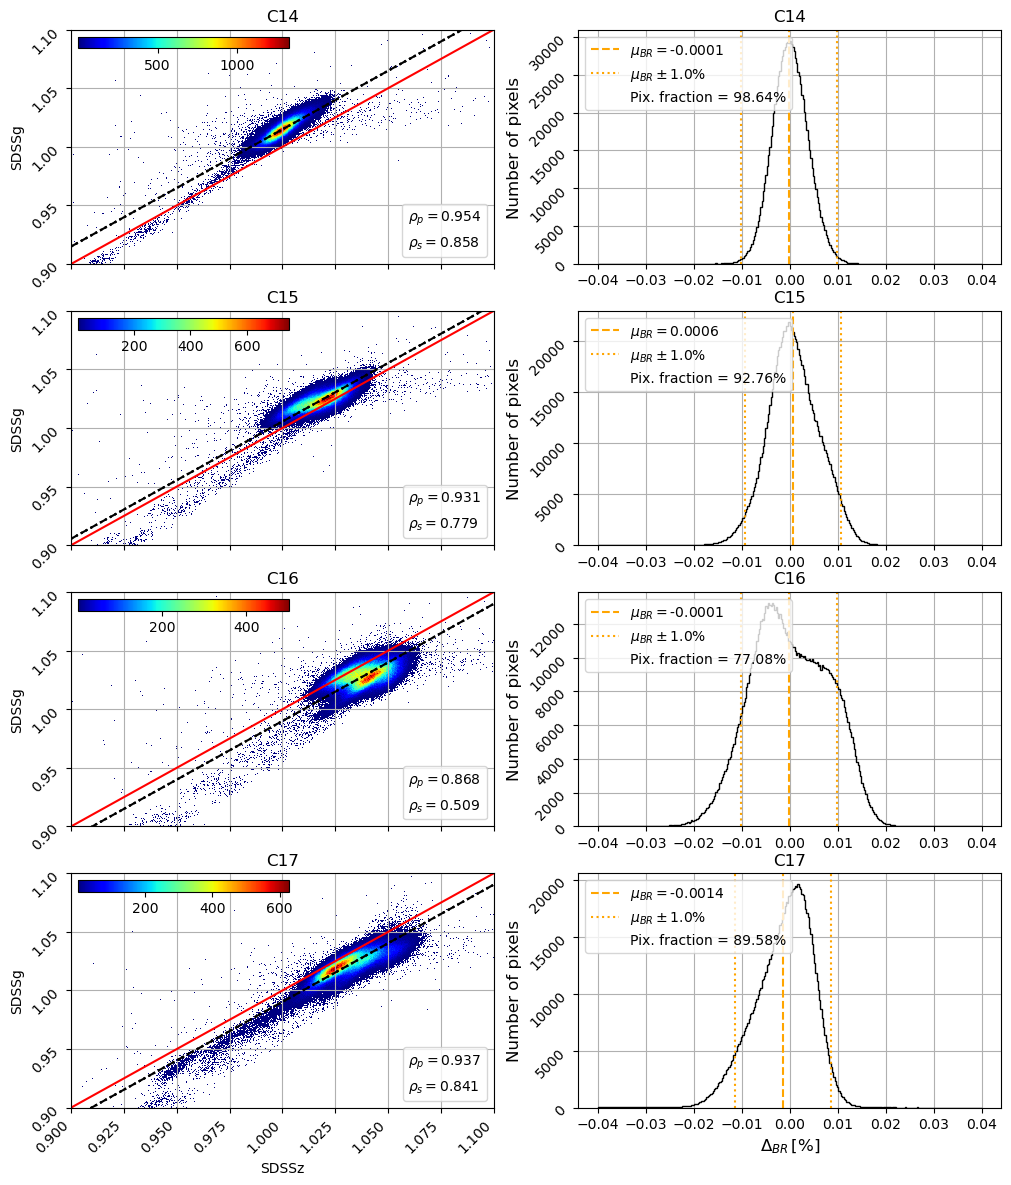

In [20]:
%matplotlib inline
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12,14))

percent = 1.0

for i,ampli_ in enumerate(ampli_seq[4:8]):
    #print(ampli_)
    
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue_ = flat_blue[1].data[y0_:y1_,x0_:x1_].flatten()
    dred_ = flat_red[1].data[y0_:y1_,x0_:x1_].flatten()
    
    make_2d_histogram(dred_,dblue_,percent,fval_min,fval_max,fig,axs[i,0],ampli_)

    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(),rotation=45.,ha='right')
    axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(),rotation=45.,ha='right')
    if i!=nrows-1:
        axs[i,0].set_xlabel('')
        axs[i,0].set_xticklabels([])

    
    dblue_ = dblue_/np.median(dblue_)
    dred_ = dred_/np.median(dred_)
    dper_filters_ = (dblue_-dred_)/dred_
    mean_per_filters_ = np.mean(dper_filters_)

    per_mask_ = (dper_filters_>=-percent/100.)*(dper_filters_<=percent/100.)
    pixels_in_ = len(dper_filters_[per_mask_])*100./len(dper_filters_)
    
    axs[i,1].hist(dper_filters_,bins=300,range=(-0.04,0.04),histtype='step',color='k')
    axs[i,1].axvline(x=mean_per_filters_,ls='--',color='orange',label=r'$\mu_{BR} = $'+'{0:.4f}'.format(mean_per_filters_))
    axs[i,1].axvline(x=mean_per_filters_+percent/100.,ls=':',color='orange',label=r'$\mu_{BR} \pm $'+'{0}%'.format(percent))
    axs[i,1].axvline(x=mean_per_filters_-percent/100.,ls=':',color='orange')
    axs[i,1].plot([],[],ls='',label='Pix. fraction = {0:.2f}%'.format(pixels_in_))
    axs[i,1].grid()
    axs[i,1].set_xlabel(r'$\Delta_{BR} \, [\%]$',fontsize=12)
    axs[i,1].set_ylabel('Number of pixels',fontsize=12)
    axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
    axs[i,1].set_title(ampli_)
    axs[i,1].legend(loc="upper left")
    
    if i!=nrows-1:
        axs[i,1].set_xlabel('')
    
plt.savefig(os.path.join(outdir,'dispersion_plots_up_paper_2.png'))


/tmp/ipykernel_2930/1255418855.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1255418855.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1255418855.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1255418855.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)


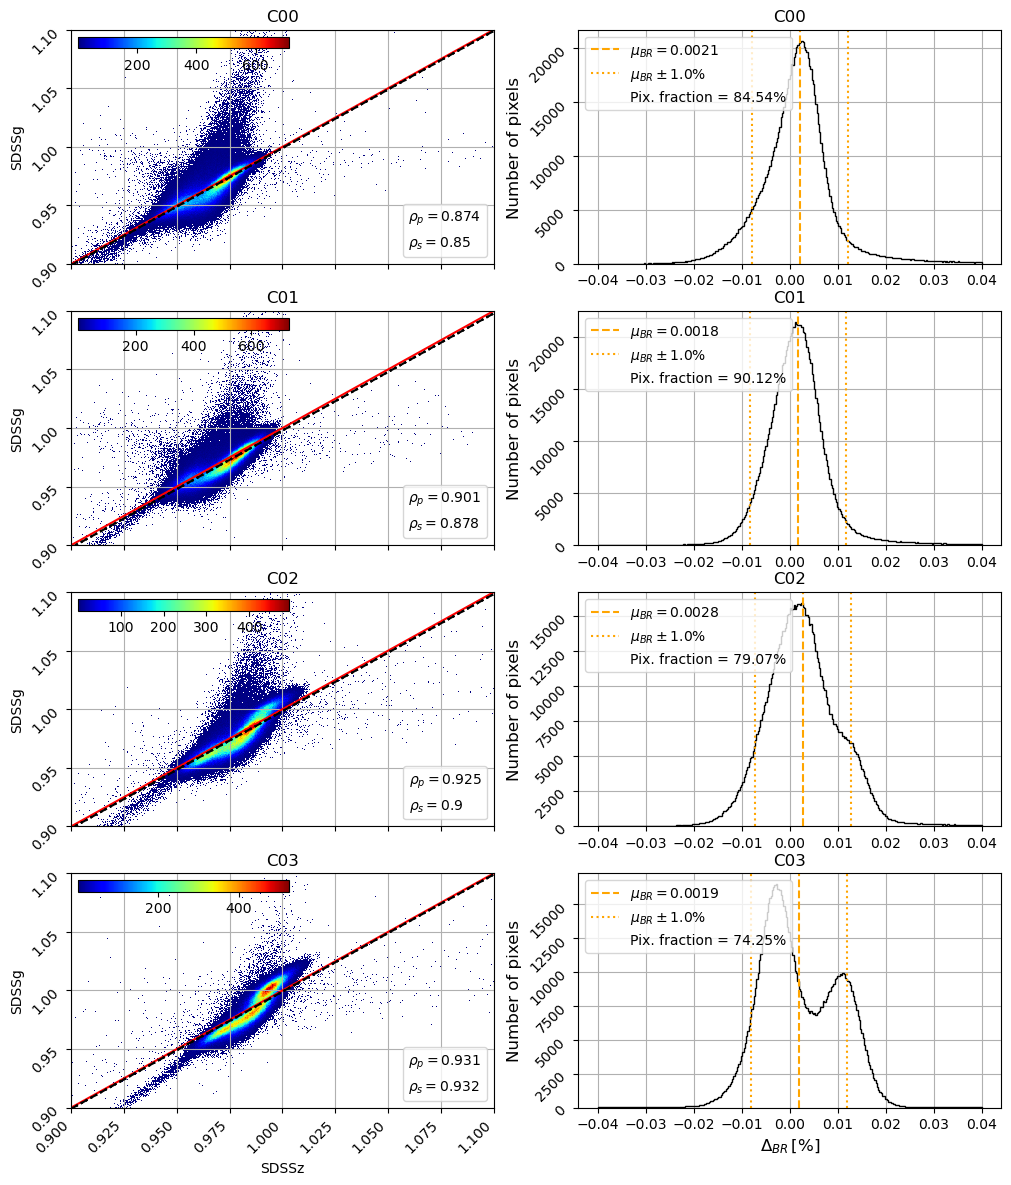

In [21]:
%matplotlib inline
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12,14))

percent = 1.0

for i,ampli_ in enumerate(ampli_seq[8:12]):
    #print(ampli_)
    
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue_ = flat_blue[1].data[y0_:y1_,x0_:x1_].flatten()
    dred_ = flat_red[1].data[y0_:y1_,x0_:x1_].flatten()
    
    make_2d_histogram(dred_,dblue_,percent,fval_min,fval_max,fig,axs[i,0],ampli_)

    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(),rotation=45.,ha='right')
    axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(),rotation=45.,ha='right')
    if i!=nrows-1:
        axs[i,0].set_xlabel('')
        axs[i,0].set_xticklabels([])

    
    dblue_ = dblue_/np.median(dblue_)
    dred_ = dred_/np.median(dred_)
    dper_filters_ = (dblue_-dred_)/dred_
    mean_per_filters_ = np.mean(dper_filters_)

    per_mask_ = (dper_filters_>=-percent/100.)*(dper_filters_<=percent/100.)
    pixels_in_ = len(dper_filters_[per_mask_])*100./len(dper_filters_)
    
    axs[i,1].hist(dper_filters_,bins=300,range=(-0.04,0.04),histtype='step',color='k')
    axs[i,1].axvline(x=mean_per_filters_,ls='--',color='orange',label=r'$\mu_{BR} = $'+'{0:.4f}'.format(mean_per_filters_))
    axs[i,1].axvline(x=mean_per_filters_+percent/100.,ls=':',color='orange',label=r'$\mu_{BR} \pm $'+'{0}%'.format(percent))
    axs[i,1].axvline(x=mean_per_filters_-percent/100.,ls=':',color='orange')
    axs[i,1].plot([],[],ls='',label='Pix. fraction = {0:.2f}%'.format(pixels_in_))
    axs[i,1].grid()
    axs[i,1].set_xlabel(r'$\Delta_{BR} \, [\%]$',fontsize=12)
    axs[i,1].set_ylabel('Number of pixels',fontsize=12)
    axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
    axs[i,1].set_title(ampli_)
    axs[i,1].legend(loc="upper left")
    
    if i!=nrows-1:
        axs[i,1].set_xlabel('')
    
plt.savefig(os.path.join(outdir,'dispersion_plots_down_paper_1.png'))


/tmp/ipykernel_2930/1491378643.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1491378643.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1491378643.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
/tmp/ipykernel_2930/1491378643.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)


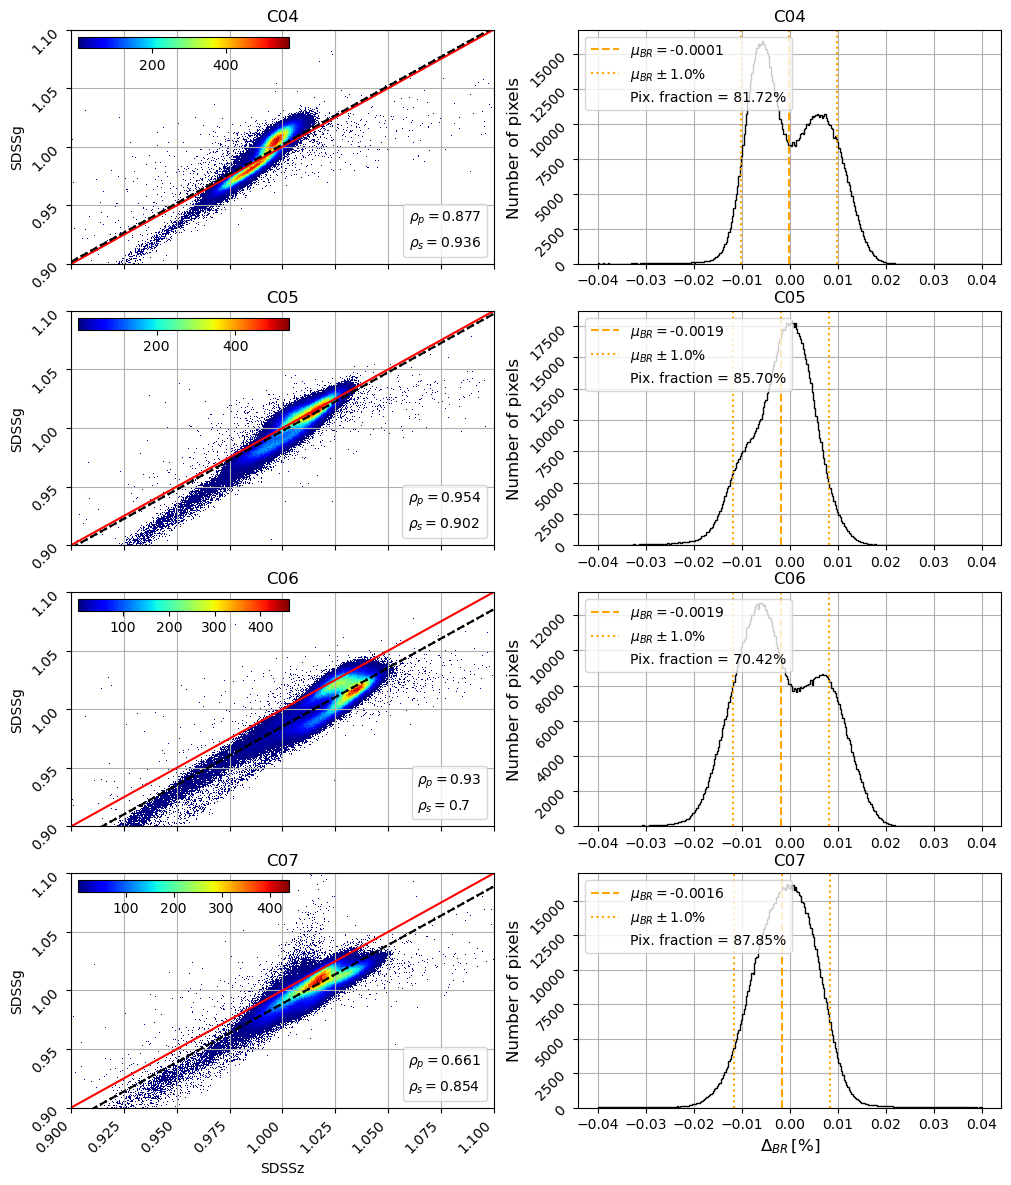

In [22]:
%matplotlib inline
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12,14))

percent = 1.0

for i,ampli_ in enumerate(ampli_seq[12:]):
    #print(ampli_)
    
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue_ = flat_blue[1].data[y0_:y1_,x0_:x1_].flatten()
    dred_ = flat_red[1].data[y0_:y1_,x0_:x1_].flatten()
    
    make_2d_histogram(dred_,dblue_,percent,fval_min,fval_max,fig,axs[i,0],ampli_)

    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(),rotation=45.,ha='right')
    axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(),rotation=45.,ha='right')
    if i!=nrows-1:
        axs[i,0].set_xlabel('')
        axs[i,0].set_xticklabels([])

    
    dblue_ = dblue_/np.median(dblue_)
    dred_ = dred_/np.median(dred_)
    dper_filters_ = (dblue_-dred_)/dred_
    mean_per_filters_ = np.mean(dper_filters_)

    per_mask_ = (dper_filters_>=-percent/100.)*(dper_filters_<=percent/100.)
    pixels_in_ = len(dper_filters_[per_mask_])*100./len(dper_filters_)
    
    axs[i,1].hist(dper_filters_,bins=300,range=(-0.04,0.04),histtype='step',color='k')
    axs[i,1].axvline(x=mean_per_filters_,ls='--',color='orange',label=r'$\mu_{BR} = $'+'{0:.4f}'.format(mean_per_filters_))
    axs[i,1].axvline(x=mean_per_filters_+percent/100.,ls=':',color='orange',label=r'$\mu_{BR} \pm $'+'{0}%'.format(percent))
    axs[i,1].axvline(x=mean_per_filters_-percent/100.,ls=':',color='orange')
    axs[i,1].plot([],[],ls='',label='Pix. fraction = {0:.2f}%'.format(pixels_in_))
    axs[i,1].grid()
    axs[i,1].set_xlabel(r'$\Delta_{BR} \, [\%]$',fontsize=12)
    axs[i,1].set_ylabel('Number of pixels',fontsize=12)
    axs[i,1].set_yticklabels(axs[i,1].get_yticklabels(),rotation=45.)
    axs[i,1].set_title(ampli_)
    axs[i,1].legend(loc="upper left")
    
    if i!=nrows-1:
        axs[i,1].set_xlabel('')
    
plt.savefig(os.path.join(outdir,'dispersion_plots_down_paper_2.png'))


/tmp/ipykernel_2930/467444217.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/tmp/ipykernel_2930/467444217.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


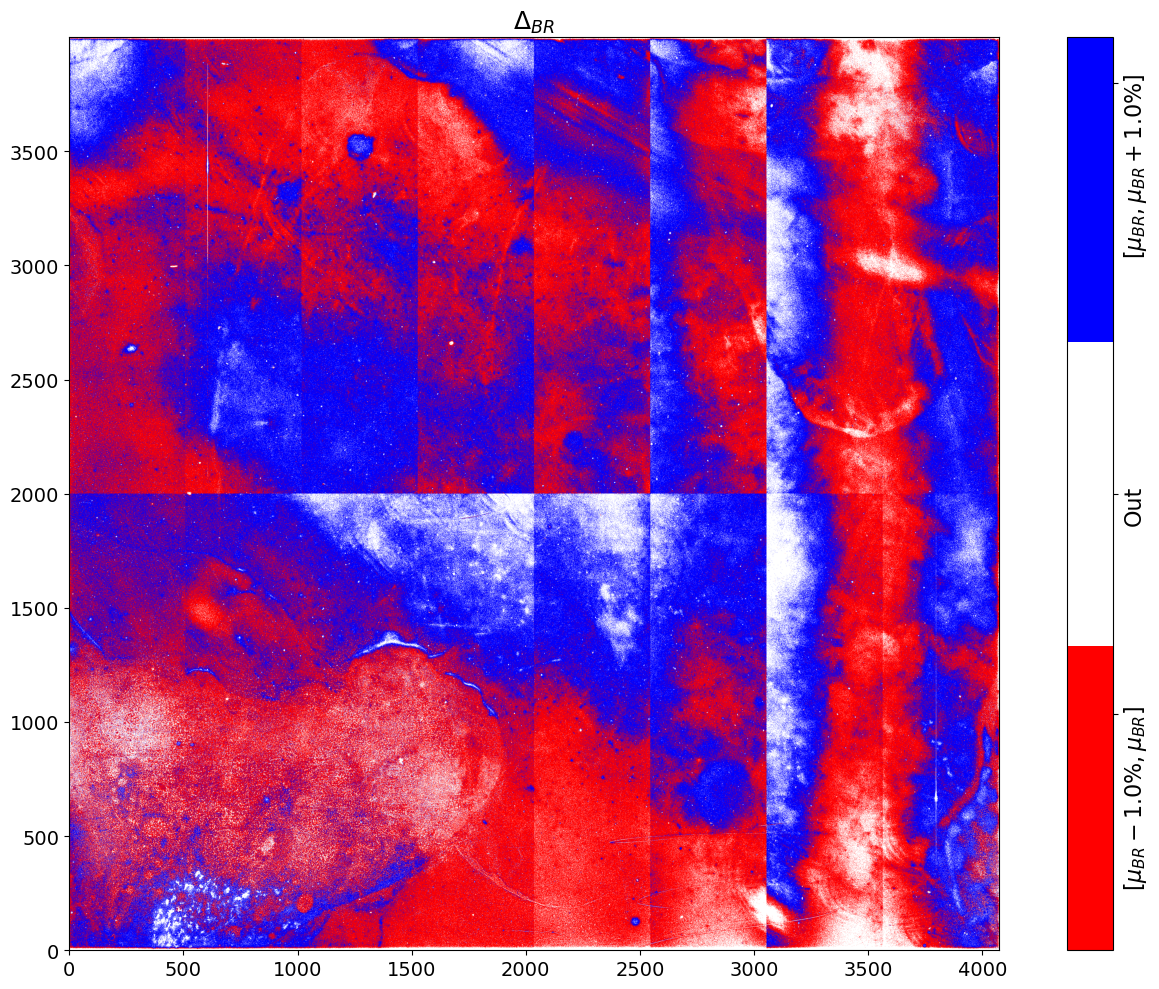

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

percent = 1.0

color_dict_ = {-1:'r',0:'w',1:'b'}
cm_ = ListedColormap(colors=list(color_dict_.values()))
mask_labels_ = [r'$[\mu_{BR}-$'+'{0}%'.format(percent)+r'$, \mu_{BR}]$',
                'Out',
                r'$[\mu_{BR}, \mu_{BR}+$'+'{0}%]'.format(percent)]

regions_array = np.zeros(flat_shape).astype('int')
for i,ampli_ in enumerate(ampli_seq):
    x0_ = ampli_coords[ampli_][0]
    x1_ = ampli_coords[ampli_][1]
    y0_ = ampli_coords[ampli_][2]
    y1_ = ampli_coords[ampli_][3]
    
    dblue_ = flat_blue[1].data[y0_:y1_,x0_:x1_]
    dred_ = flat_red[1].data[y0_:y1_,x0_:x1_]
    
    dblue_ = dblue_/np.median(dblue_)
    dred_ = dred_/np.median(dred_)

    dper_filters_ = (dblue_-dred_)/dred_
    mean_per_filters_ = np.mean(dper_filters_)

    #############################
    xmin_diff_ = np.max(dper_filters_[dper_filters_<=mean_per_filters_-percent/100.])
    xmax_diff_ = np.min(dper_filters_[dper_filters_>=mean_per_filters_+percent/100.])

    if i==0:
        ampli_shape = flat_blue[1].data[y0_:y1_,x0_:x1_].shape
    
    sides_mask_ = np.zeros(ampli_shape).astype('int')
    left_mask_ = (dper_filters_>=xmin_diff_)*(dper_filters_<=mean_per_filters_)
    right_mask_ = (dper_filters_>mean_per_filters_)*(dper_filters_<=xmax_diff_)
    
    regions_array[y0_:y1_,x0_:x1_][left_mask_] = -1
    regions_array[y0_:y1_,x0_:x1_][right_mask_] = 1
    
im = ax.imshow(regions_array,cmap=cm_,origin='lower')#,vmin=0,vmax=1)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

cbar = fig.colorbar(im,ax=ax)
yticks = np.linspace(*cbar.ax.get_ylim(), cm_.N+1)[:-1]
yticks = [yticks[1]*1.45,(yticks[1]+(yticks[1]-yticks[0])/2)*0.95,(yticks[2]+(yticks[1]-yticks[0]))*0.9]
cbar.set_ticks(yticks)
cbar.set_ticklabels(ticklabels=mask_labels_,rotation=90)
cbar.ax.tick_params(labelsize=16)
ax.set_title(r'$\Delta_{BR}$',fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(outdir,'flat_regions_{0:.2f}percent.png'.format(percent)))